# Import and configurations

In [3]:
from nyuv2_dataset import NYUv2Dataset
from cityscapes_dataset import CityscapesDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from cross_stitchnet import CrossStitchNet
from densenet import DenseNet
from depthnet import DepthNet
from splitnet import SplitNet
from stan import STAN
from mtan import MTAN
from segnet import SegNet
from normalnet import NormalNet
from trainer import Trainer
from utils import count_params, visualize_results

In [16]:
dataset_string = 'cityscapes'
tasks = ['segmentation', 'depth'] if dataset_string == 'cityscapes' else ['segmentation', 'depth', 'normal']
depth_activation = nn.ReLU() if dataset_string == 'cityscapes' else nn.Sigmoid()
BATCH_SIZE = 8 if dataset_string == 'cityscapes' else 2
LR = 1e-4
filter = [64, 128, 256, 512, 512] 

In [17]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


# Data Loading

In [18]:
if dataset_string == 'nyuv2':
    print("NYUv2 Dataset")
    nyuv2_train = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='train')
    classes = nyuv2_train.get_classes()

    nyuv2_val = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='val')
    train_dl = DataLoader(nyuv2_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(nyuv2_val, batch_size=BATCH_SIZE, shuffle=False)

    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)) + ',' + ' Normals: ' + str(list(out['normal'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ',' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        print('Normals: ' + str(out['normal'].max().item()) + ', ' + str(out['normal'].min().item()))
        break
else:
    print("Cityscapes Dataset")
    cityscapes_train = CityscapesDataset(root="../dataset/cityscapes_preprocessed")
    cityscapes_val = CityscapesDataset(root="../dataset/cityscapes_preprocessed", split='val')
    train_dl = DataLoader(cityscapes_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(cityscapes_val, batch_size=BATCH_SIZE, shuffle=False)
    classes = cityscapes_train.get_classes()
    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ', ' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        break
print(f"Number of classes: {classes}")

Cityscapes Dataset
Image: [8, 3, 128, 256], Label: [8, 128, 256], Depth: [8, 128, 256]
Image: 1.0, 0.0
Label: 6.0, -1.0
Depth: 0.4922102689743042, 0.0
Number of classes: 7


# Model Definitions and Dimensions

In [19]:
cross = CrossStitchNet(filter=filter, classes=classes, mid_layers=1, tasks=tasks, depth_activation=depth_activation)
dense = DenseNet(filter=filter, classes=classes, mid_layers=0, tasks=tasks, depth_activation=depth_activation)
depth = DepthNet(filter=filter, mid_layers=6, depth_activation=depth_activation)
mtan = MTAN(filter=filter, mid_layers=0 , classes=classes, tasks=tasks, depth_activation=depth_activation)
norm = NormalNet(filter=filter, mid_layers=6)
seg = SegNet(filter=filter, mid_layers=6, classes=classes)
split = SplitNet(filter=filter, mid_layers=6, classes=classes, tasks=tasks, depth_activation=depth_activation)
stan = STAN(filter=filter, mid_layers=4, classes=classes, task=tasks[0], depth_activation=depth_activation)

In [20]:
mtan_params = count_params(mtan)
cross_params = count_params(cross)
dense_params = count_params(dense)
depth_params = count_params(depth)
norm_params = count_params(norm)
seg_params = count_params(seg)
split_params = count_params(split)
stan_params = count_params(stan)
print(f"MTAN: {mtan_params}")
print(f"Cross: {cross_params}, {cross_params>=mtan_params}")
print(f"Dense: {dense_params}, {dense_params>=mtan_params}")
print(f"Depth: {depth_params}, {depth_params>=mtan_params}")
print(f"Norm: {norm_params}, {norm_params>=mtan_params}")
print(f"Seg: {seg_params}, {seg_params>=mtan_params}")
print(f"Split: {split_params}, {split_params>=mtan_params}")
print(f"STAN: {stan_params}, {stan_params>=mtan_params}")

MTAN: 42920969
Cross: 50094285, True
Dense: 77970569, True
Depth: 65399681, True
Norm: 65399811, True
Seg: 65400136, True
Split: 65511177, True
STAN: 64396232, True


# Model Training

In [ ]:
model = mtan.to(device)
print(f"{model.name} has {count_params(model)} parameters")

mtan_seg_dep_nor has 56118289 parameters


In [6]:
opt = torch.optim.Adam(model.parameters(), lr=LR)
trainer = Trainer(model, opt, dataset_string, device, dwa=True, save_path='../')

100%|██████████| 398/398 [01:56<00:00,  3.40it/s]


Epoch 1/2 - train total loss: 4.5621
lambda_segmentation : 1.0 - train loss segmentation: 2.1566
lambda_depth : 1.0 - train loss depth: 2.0017
lambda_normal : 1.0 - train loss normal: 0.4039
miou: 0.0669
pix_acc: 0.4260
mae: 1.9851
mre: 0.6573
ad: 52.0880
gradient norm: 2.0552



100%|██████████| 327/327 [00:31<00:00, 10.49it/s]


val loss segmentation: 1.9144
val loss depth: 1.7820
val loss normal: 0.3269
val loss total: 4.0233
miou: 0.0865
pix_acc: 0.4718
mae: 1.7677
mre: 0.5925
ad: 46.1437




100%|██████████| 398/398 [01:58<00:00,  3.36it/s]


Epoch 2/2 - train total loss: 3.9858
lambda_segmentation : 1.0025192499160767 - train loss segmentation: 1.8218
lambda_depth : 1.047357201576233 - train loss depth: 1.8661
lambda_normal : 0.9501233696937561 - train loss normal: 0.2979
miou: 0.0925
pix_acc: 0.4891
mae: 1.8446
mre: 0.5956
ad: 44.4152
gradient norm: 1.6723



100%|██████████| 327/327 [00:31<00:00, 10.44it/s]


val loss segmentation: 1.7949
val loss depth: 1.7425
val loss normal: 0.2922
val loss total: 3.8297
miou: 0.0890
pix_acc: 0.4756
mae: 1.7282
mre: 0.5760
ad: 43.0977




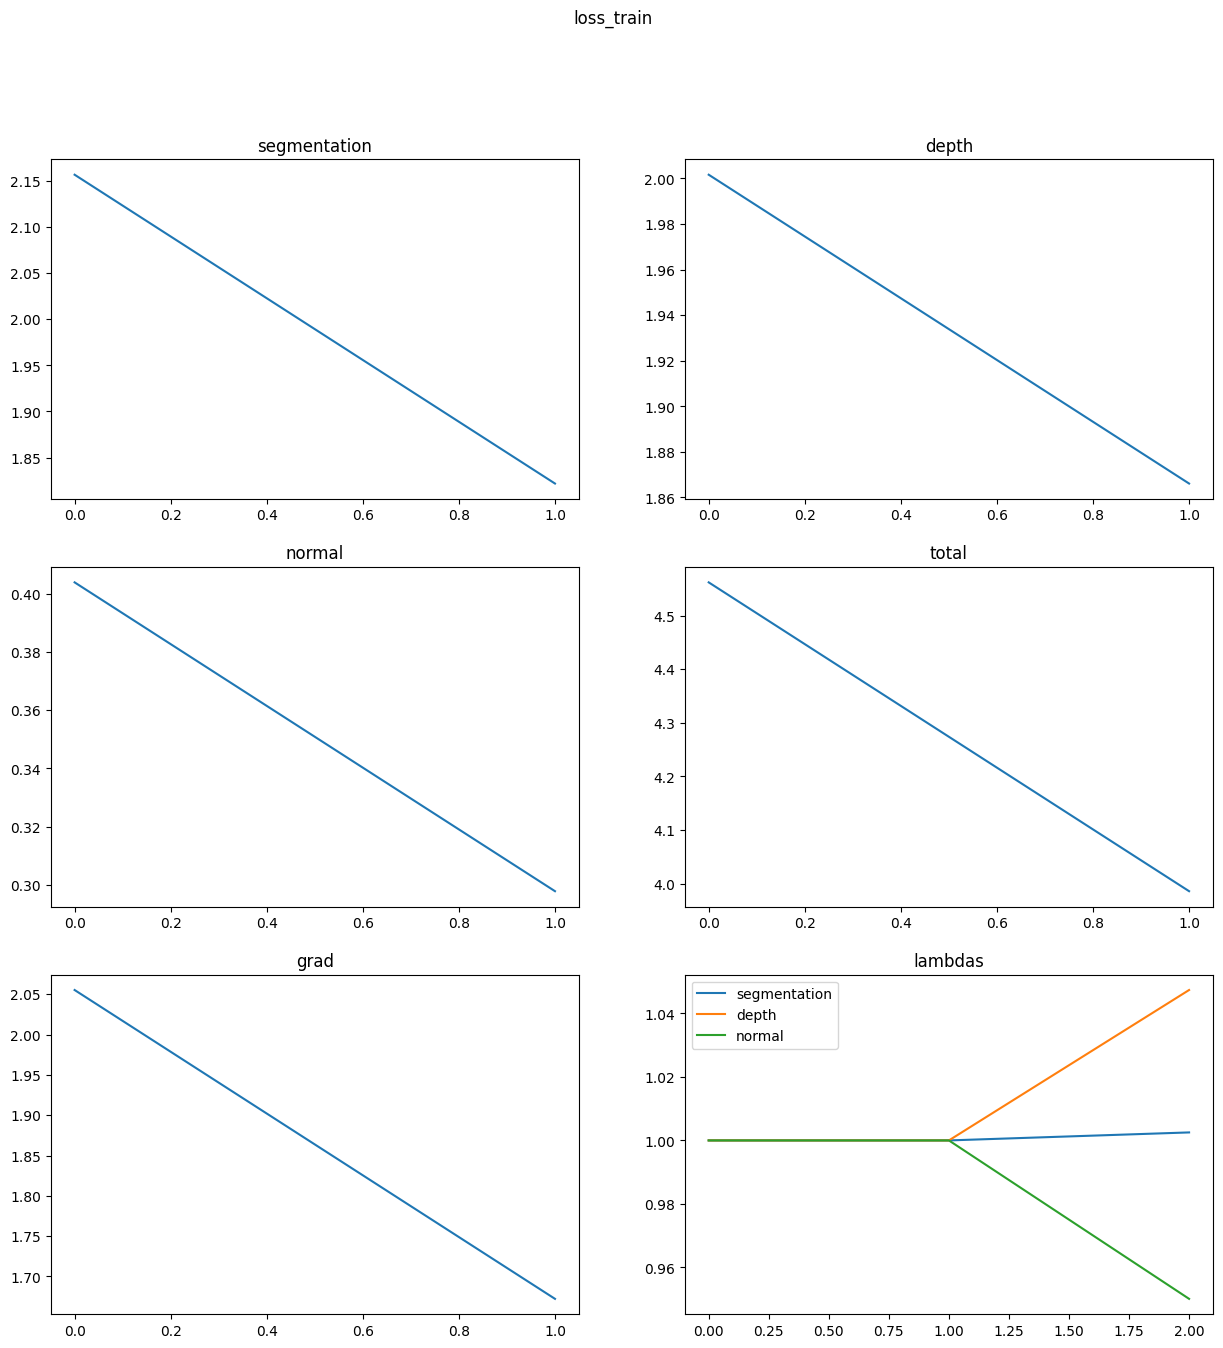

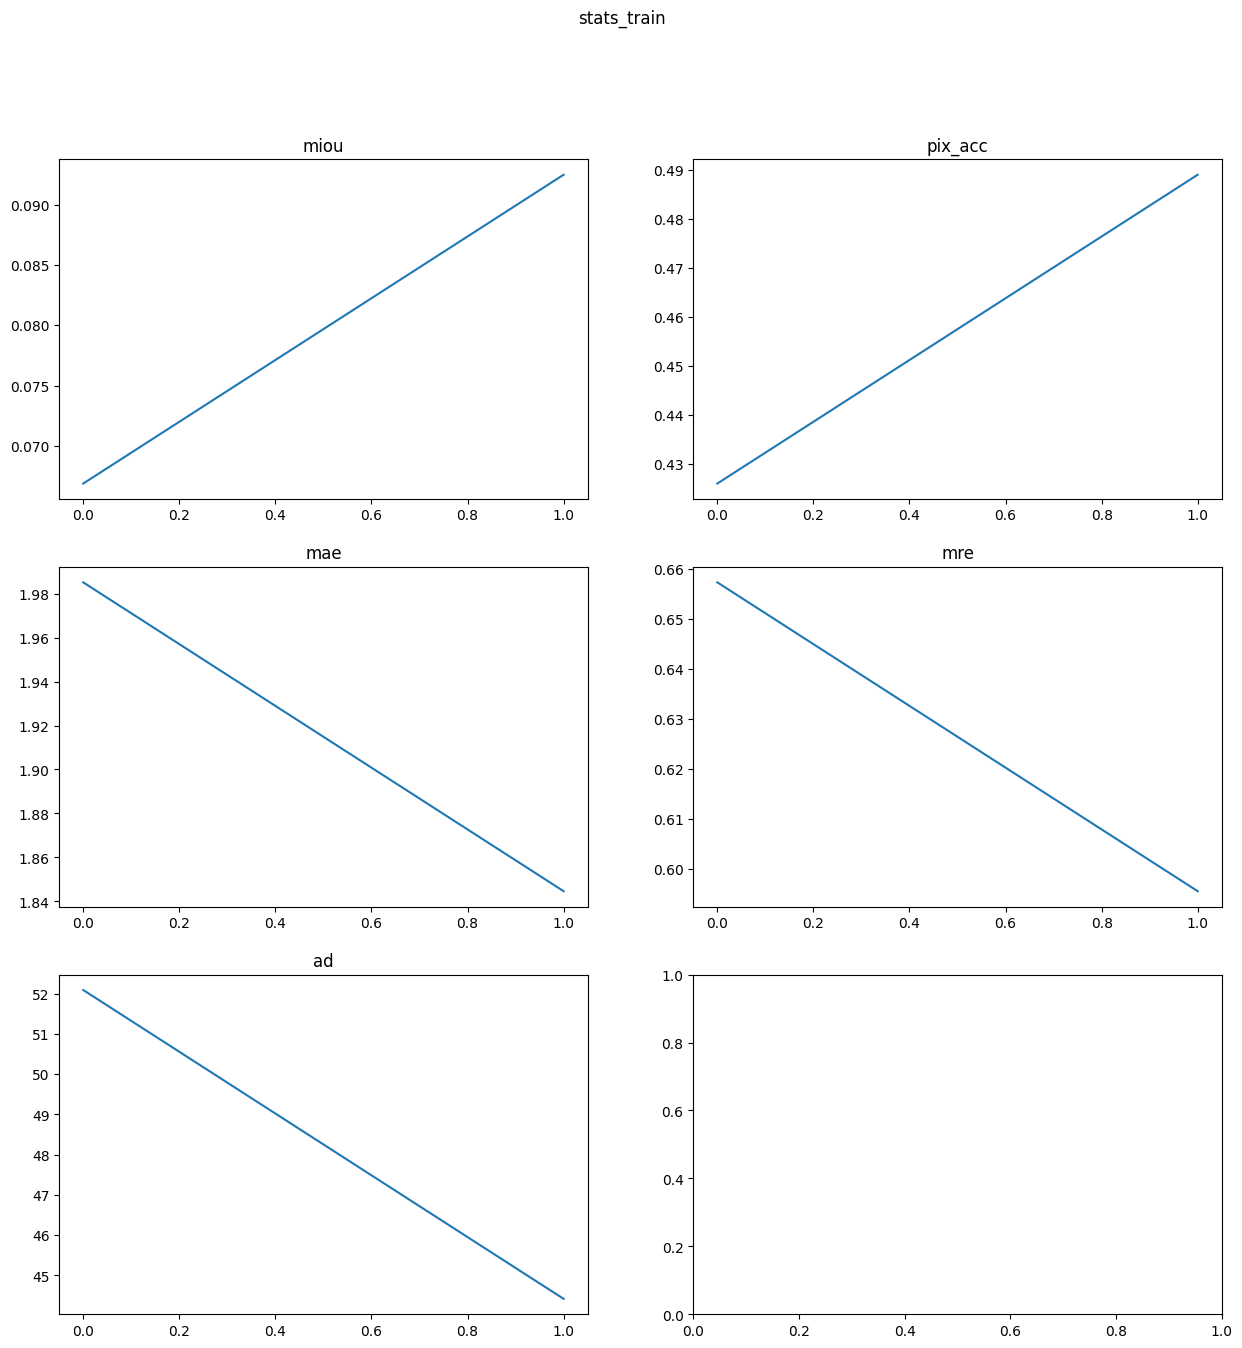

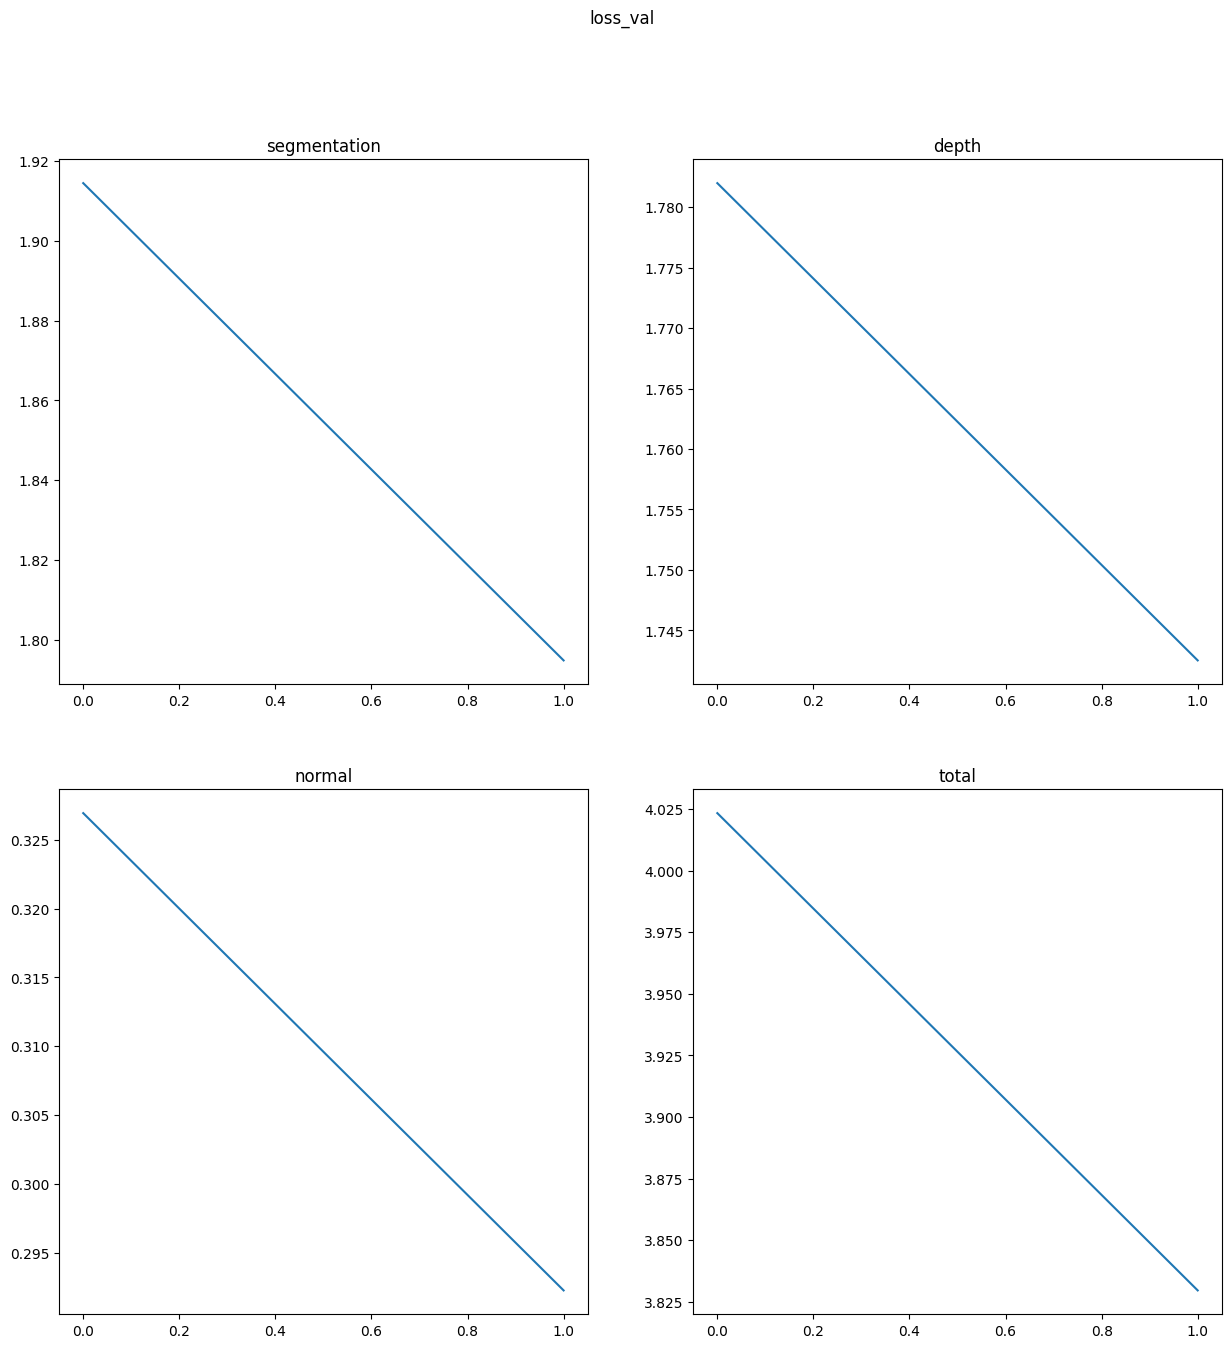

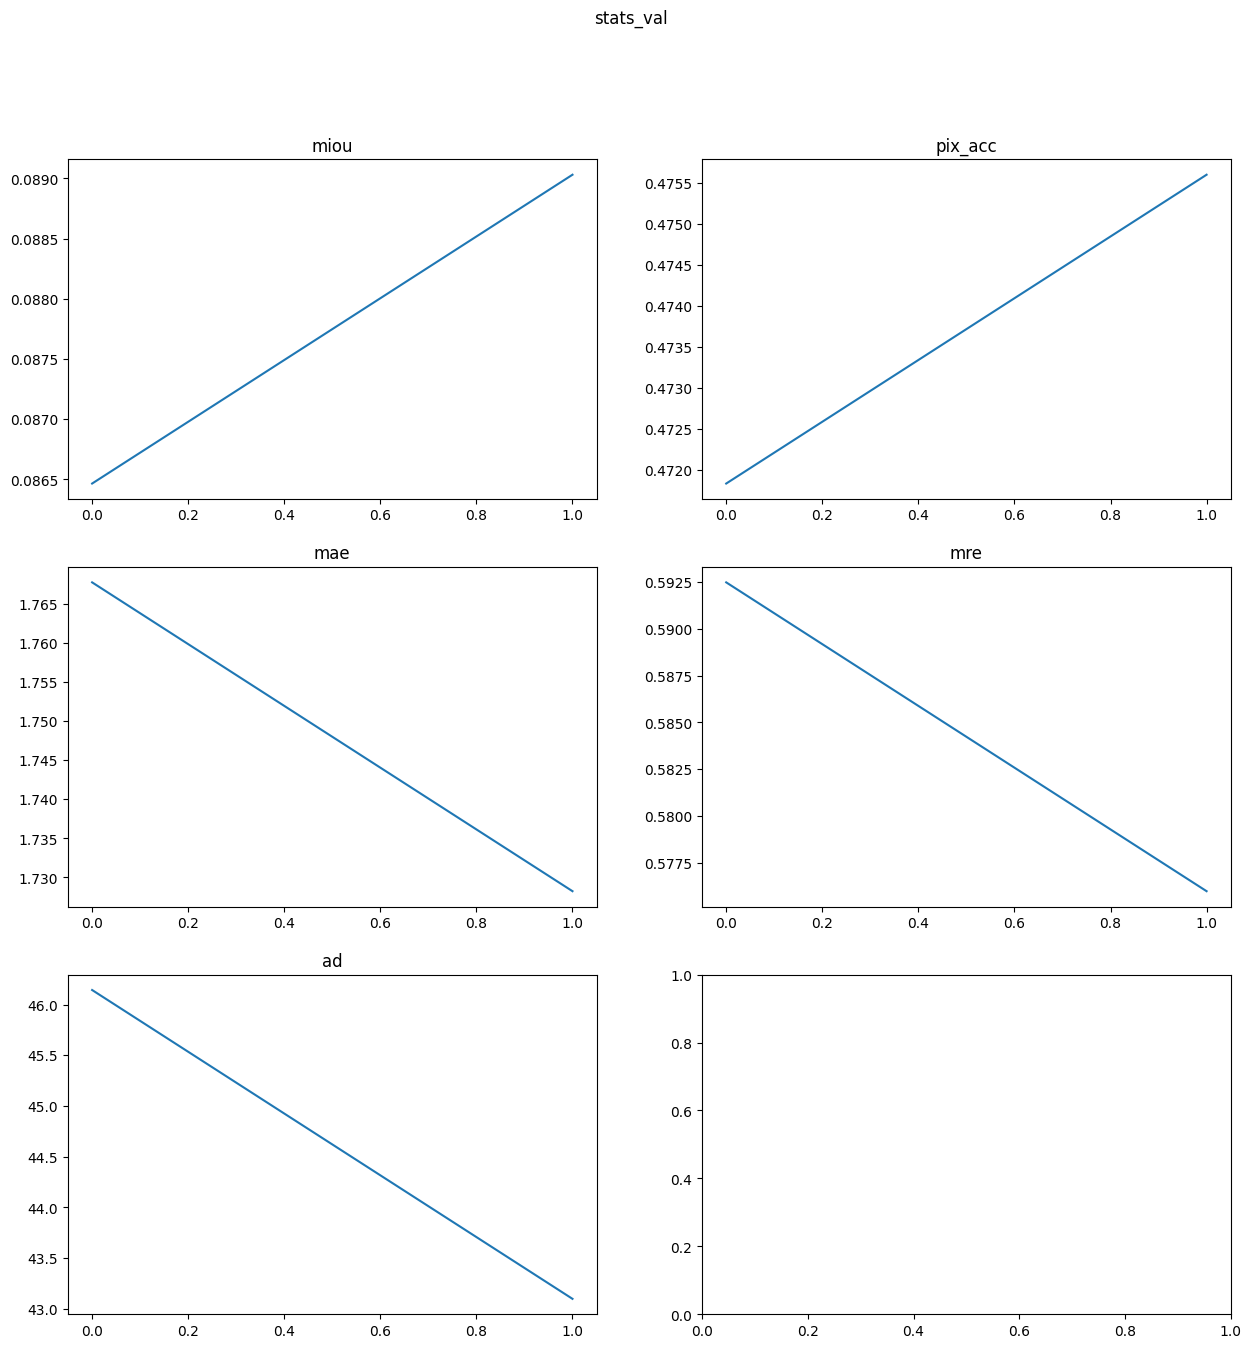

In [7]:
trainer.train(train_dl, val_dl, epochs=2, save=True, check=1, grad=True)

# Model Evaluation

In [ ]:
# filter = [64, 128, 256, 512, 512]
# mid_layers = 0
# classes= 7
# depth_activation = nn.ReLU()
# tasks = ["segmentation", "depth"]

dwa_model = False
model = MTAN(classes=classes, tasks=tasks, depth_activation=depth_activation)
# model = NormalNet(mid_layers=5)
path = f'../models/{dataset_string}/{model.name}'
if len(model.tasks) > 1:
    path += '_dwa' if dwa_model else '_equal'
path += f'/{model.name}_2.pth'
print(path)
model.load_state_dict(torch.load(path, weights_only=True))

In [ ]:
nresults = 10
id_result = 0
for i, (image, out) in enumerate(val_dl):
    state = visualize_results(model, device, image, out, id_result, nresults, out=True, save_path='../')
    id_result += BATCH_SIZE
    if state:
        break